<a href="https://colab.research.google.com/github/supertime1/BP_PPG/blob/master/Prepare_train_val_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1.Introduction

This notebook trains an simple PPG DNN by using labeled PPG data from Afib_Data_Clean notebook;
The loaded data is 30s segemented PPG signals with 125Hz sampling rate.

#2.Setup Environment



In [0]:
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext tensorboard
import numpy as np
import os
import shutil
import glob
import wfdb
from wfdb import processing
from datetime import datetime
import sklearn.metrics
import itertools
import io
import pickle

#3.Prepare train, val and test data

In [0]:
#ratio value is between 0 and 1
#make sure seed is set to a same number for repeatable results\
#or to compare models apple to apple
def slice_dataset(dataset,labels,train_ratio,seed = 10):  
  DATASET_SIZE =len(list(dataset)) #only works in eager mode (e.g. TF version >= 2.0.x)
  train_size = int(train_ratio * DATASET_SIZE)
  val_size = DATASET_SIZE - train_size
  
  np.random.seed(seed=seed)
  np.random.shuffle(dataset)
  train_dataset = dataset[:train_size,:,:]
  val_dataset = dataset[-val_size:,:,:]

  np.random.seed(seed=seed)
  np.random.shuffle(labels)
  train_labels = labels[:train_size,:]
  val_labels = labels[-val_size:,:]

  return train_dataset,val_dataset,train_labels, val_labels

In [0]:
#Resample_reshape_slice_data:
#1.Resample the data from original 125Hz to specified frequency (sf)
#2.reshape the data from [NONE, 60*sampling frequency(sf)] to [NONE,ts,60*sf/ts,1] 
#  (e.g.from [NONE, 7500] to [NONE, 10, 750, 1]), where 60*sf/ts mush be an positive integer
#3.Create train,validation and test dataset

#input:
#     sf: sampling frequency, if other than orginal 125Hz
#     ts: timesteps that define how many images/signals were fed into LSTM
#     t_ratio: test dataset ratio to (train+validation) dataset
#     val_ratio: validation dataset ratio to train dataset

#output:
#     save reshaped and shuffled dataset per 1min into train,validatin,test folders that are
#     created **BEFORE** calling this function

def resample_reshape_slice_data(directory,sf = 125, ts=6,t_ratio = 0.05, val_ratio = 0.1):
  #load data
  PPG_names = glob.glob(directory + "BP_data*")
  label_names = glob.glob(directory + "BP_label*")
  
  assert(len(PPG_names) == len(label_names))

  for i in range(len(PPG_names)):
    
    #skip in case there is empty file

    if os.path.getsize(PPG_names[i]) < 5*1024: continue

    print("processing", i, "th data")

    with open(PPG_names[i], "rb") as fp:
      raw_signals = pickle.load(fp)

    with open(label_names[i], "rb") as fp:
      raw_labels = pickle.load(fp)

    
    #resample to specified frequency sf
    
    resamp_PPG_signals = []
    for k in range(len(raw_signals)):
      resamp_PPG_signal, _ = wfdb.processing.resample_sig(raw_signals[k],125,sf)
      resamp_PPG_signals.append(resamp_PPG_signal)

    #create the right dim for signals
    raw_signals = np.array(resamp_PPG_signals)
    raw_signals = np.reshape(raw_signals,[len(raw_signals),ts,int(60*sf/ts)])
    raw_signals = np.expand_dims(raw_signals, axis=3)
    raw_labels = np.array(raw_labels)

    train_dataset, test_dataset, train_labels, test_labels  = slice_dataset(raw_signals,raw_labels,1-t_ratio)
    train_dataset, val_dataset, train_labels, val_labels  = slice_dataset(train_dataset,train_labels,1-val_ratio)

    with open(directory + "train125/"+"data_" + str(i), "wb") as fp:
      pickle.dump(train_dataset,fp)
    
    with open(directory + "train125/"+"label_" + str(i), "wb") as fp:
      pickle.dump(train_labels,fp)    
    
    with open(directory + "validation125/"+"data_" + str(i), "wb") as fp:
      pickle.dump(val_dataset,fp)
    
    with open(directory + "validation125/"+"label_" + str(i), "wb") as fp:
      pickle.dump(val_labels,fp)                
    
    with open(directory + "test125/"+"data_" + str(i), "wb") as fp:
      pickle.dump(test_dataset,fp)
    
    with open(directory + "test125/"+"label_" + str(i), "wb") as fp:
      pickle.dump(test_labels,fp)  

  return None

In [5]:
directory = 'D:/WFDB/matched/BP/New Cleaned Data/'
resample_reshape_slice_data(directory,sf = 125)

processing 0 th data
processing 1 th data
processing 2 th data
processing 3 th data
processing 4 th data
processing 5 th data
processing 6 th data
processing 7 th data
processing 8 th data
processing 9 th data
processing 10 th data
processing 11 th data
processing 12 th data
processing 13 th data
processing 14 th data
processing 15 th data
processing 16 th data
processing 17 th data
processing 18 th data
processing 19 th data
processing 20 th data
processing 21 th data
processing 22 th data
processing 23 th data
processing 24 th data
processing 25 th data
processing 26 th data
processing 27 th data
processing 28 th data
processing 29 th data
processing 30 th data
processing 31 th data
processing 32 th data
processing 33 th data
processing 34 th data
processing 35 th data
processing 36 th data
processing 37 th data
processing 38 th data
processing 39 th data
processing 40 th data
processing 41 th data
processing 42 th data
processing 43 th data
processing 44 th data
processing 45 th dat

#4.Check BP distribution




In [0]:
#concatenate label
def concatenate_label(directory):
  raw_labels_list = []

  for name in glob.glob(directory):

    with open(name, "rb") as fp:
      raw_label = pickle.load(fp)
    
    raw_labels_list.append(raw_label)
  
  raw_labels = [y for x in raw_labels_list for y in x]

    
  return raw_labels

In [0]:
directory = 'D:/WFDB/matched/BP/New Cleaned Data/'
train_dir = directory + "train/label*"
train_labels = concatenate_label(train_dir)
train_labels = np.array(train_labels)

Systolic BP has a mean value of: 127.1 and a STD of: 23.6
Diastolic BP has a mean value of: 60.3 and a STD of: 13.0


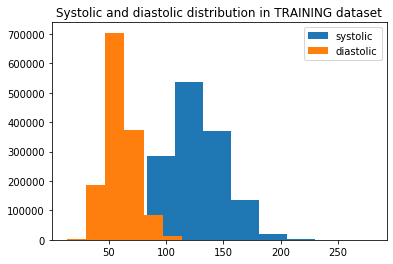

In [26]:
#check sys and dia distribution in train dataset
plt.title("Systolic and diastolic distribution in TRAINING dataset")
plt.hist(train_labels[:,0], label="systolic")
plt.hist(train_labels[:,1],label="diastolic")
plt.legend()
sys_std = round(np.std(train_labels[:,0]),1)
sys_mean = round(np.mean(train_labels[:,0]),1)
print("Systolic BP has a mean value of:", sys_mean, "and a STD of:", sys_std)
dia_std = round(np.std(train_labels[:,1]),1)
dia_mean = round(np.mean(train_labels[:,1]),1)
print("Diastolic BP has a mean value of:", dia_mean, "and a STD of:", dia_std)

In [0]:
directory = 'D:/WFDB//matched/BP/New Cleaned Data/'
val_dir = directory + "validation/label*"
val_labels = concatenate_label(val_dir)
val_labels = np.array(val_labels)

Systolic BP has a mean value of: 127.0 and a STD of: 23.6
Diastolic BP has a mean value of: 60.3 and a STD of: 12.9


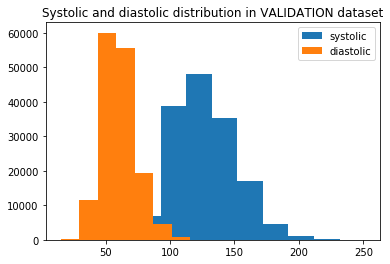

In [25]:
#check sys and dia distribution in validation dataset
plt.title("Systolic and diastolic distribution in VALIDATION dataset")
plt.hist(val_labels[:,0], label="systolic")
plt.hist(val_labels[:,1],label="diastolic")
plt.legend()
sys_std = round(np.std(val_labels[:,0]),1)
sys_mean = round(np.mean(val_labels[:,0]),1)
print("Systolic BP has a mean value of:", sys_mean, "and a STD of:", sys_std)
dia_std = round(np.std(val_labels[:,1]),1)
dia_mean = round(np.mean(val_labels[:,1]),1)
print("Diastolic BP has a mean value of:", dia_mean, "and a STD of:", dia_std)

In [0]:
directory = 'D:/WFDB//matched/BP/New Cleaned Data/'
test_dir = directory + "test/label*"
test_labels = concatenate_label(test_dir)
test_labels = np.array(test_labels)

Check the distribution of systolic and diastolic BP value

Systolic BP has a mean value of: 127.1 and a STD of: 23.7
Diastolic BP has a mean value of: 60.4 and a STD of: 13.0


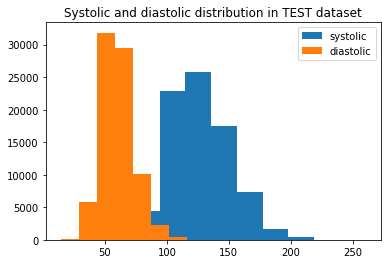

In [27]:
#check sys and dia distribution in test dataset
plt.title("Systolic and diastolic distribution in TEST dataset")
plt.hist(test_labels[:,0], label="systolic")
plt.hist(test_labels[:,1],label="diastolic")
plt.legend()
sys_std = round(np.std(test_labels[:,0]),1)
sys_mean = round(np.mean(test_labels[:,0]),1)
print("Systolic BP has a mean value of:", sys_mean, "and a STD of:", sys_std)
dia_std = round(np.std(test_labels[:,1]),1)
dia_mean = round(np.mean(test_labels[:,1]),1)
print("Diastolic BP has a mean value of:", dia_mean, "and a STD of:", dia_std)

#5.Concatenate Test data and label

In [0]:
#concatenate data
def concatenate_data(directory):
  raw_signals_list = []
  files_list = directory + "data*"
  for name in glob.glob(files_list):
    raw_signal = pickle.load(open(name,'rb'))
    raw_signals_list.append(raw_signal)
  raw_signals = [y for x in raw_signals_list for y in x]
  return raw_signals

In [0]:
#load PPG signal
test_signals = concatenate_data('C:/Users/57lzhang.US04WW4008/Desktop/Blood pressure/BP data/test/')

In [0]:
with open("C:/Users/57lzhang.US04WW4008/Desktop/Blood pressure/BP data/test/test_data", "wb") as fp:
  pickle.dump(test_signals, fp)

In [0]:
#concatenate label
def concatenate_label(directory):
  raw_labels_list = []
  files_list = directory + "label*"
  for name in glob.glob(files_list):
    raw_label = pickle.load(open(name,'rb'))
    raw_labels_list.append(raw_label)
  raw_labels = [y for x in raw_labels_list for y in x]
  return raw_labels

In [0]:
test_labels = concatenate_label('C:/Users/57lzhang.US04WW4008/Desktop/Blood pressure/BP data/test/')

In [0]:
with open('C:/Users/57lzhang.US04WW4008/Desktop/Blood pressure/BP data/test/test_labels', "wb") as fp:
  pickle.dump(test_labels, fp)